<a href="https://colab.research.google.com/github/MikelKN/new-phd-with-rawat/blob/main/Version_2_eda_sentiment_cosine_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

# Version 2: updating with feedback from MilanLP and Rick

Followig the reviews from the Coding Apperitivo, the main suggestion was to consider using similar datasets from the same sources and gernes so as to adress the huge discrepancies in the mean word length between both datasets.


So the plan is to use either social media-social media content- from twitter.

Datasets 1- hate speech : https://arxiv.org/abs/2404.17874 - MANUEL Tonneau

Dataset 2-fake news : https://www.unb.ca/cic/datasets/truthseeker-2023.html

(https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023?select=Twitter+Analysis.csv)

## reference for fake news dataset:

S. Dadkhah, X. Zhang, A. G. Weismann, A. Firouzi and A. A. Ghorbani, "The Largest Social Media Ground-Truth Dataset for Real/Fake Content: TruthSeeker," in IEEE Transactions on Computational Social Systems, 99. 1-15, Oct. 2023.


## reference for hate speech dataset:

Tonneau, M., Liu, D., Fraiberger, S., Schroeder, R., Hale, S. A., & Röttger, P. (2024). From Languages to Geographies: Towards Evaluating Cultural Bias in Hate Speech Datasets. arXiv preprint arXiv:2404.17874.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["OPEN_AI"] = userdata.get("OPEN_AI")
os.environ["HF_API_KEY"] = userdata.get("HF_API_KEY")

Mounted at /content/drive


In [2]:
import pandas as pd
# limit to the lenght of token that should be displayed on the daatsets
pd.options.display.max_colwidth = 500

import kaggle

# !kaggle datasets download -d waalbannyantudre/hate-speech-detection-curated-dataset
!kaggle datasets download -d elgringofrances/english-hate-speech-superset
!kaggle datasets download -d sudishbasnet/truthseekertwitterdataset2023

# !unzip hate-speech-detection-curated-dataset.zip
!unzip english-hate-speech-superset.zip
!unzip truthseekertwitterdataset2023.zip

!git clone https://github.com/MikelKN/abbreviation-list-english.git

fake_1 = pd.read_csv('/content/Truth_Seeker_Model_Dataset.csv')
hate_2 = pd.read_csv('/content/en_hf_102024.csv')

Dataset URL: https://www.kaggle.com/datasets/elgringofrances/english-hate-speech-superset
License(s): MIT
 88% 20.0M/22.8M [00:02<00:00, 12.7MB/s]
100% 22.8M/22.8M [00:02<00:00, 9.60MB/s]
Dataset URL: https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023
License(s): unknown
 93% 30.0M/32.2M [00:02<00:00, 19.9MB/s]
100% 32.2M/32.2M [00:02<00:00, 12.5MB/s]
Archive:  english-hate-speech-superset.zip
  inflating: en_hf_102024.csv        
Archive:  truthseekertwitterdataset2023.zip
  inflating: Truth_Seeker_Model_Dataset.csv  
  inflating: Twitter Analysis.csv    
  inflating: readme.txt              
Cloning into 'abbreviation-list-english'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 181.29 KiB | 5.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Import librabires and preprocess


In [4]:
!pip install emoji num2words contractions tqdm fire --quiet
!pip install --upgrade openai transformers --quiet
!pip install -U kaleido --quiet #to print and save the sankey charts

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('all', quiet=True)
#for lemmatizing our corpus
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from num2words import num2words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from openai import OpenAI
from tqdm import tqdm
from pathlib import Path

#for removing stop words from our corpus
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
stopwords_list = set(stopwords.words("english"))

import kaggle
import kagglehub
import emoji
import re
import os
import time
import contractions
import plotly.graph_objects as go

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import gensim.downloader as api

# limit to the lenght of token that should be displayed on the daatsets
pd.options.display.max_colwidth = 500
from IPython.display import display

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline

#use GPU if available else use CPU
import torch
from torch.nn.functional import softmax
import torch.nn.functional as F
import transformers
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Preprocessor:
    def __init__(self):

        self.patterns= {
            "multi_space": r' +',
            "user_mention": r'@\w+',
            "new_line": r'\n+',
            "hyperlink": r'https?://\S+|www\.\S+',
            "accented": r'\^[a-zA-Z0-9]+',
            "date": r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s(?:Jan|Feb|Mar|...|Dec)[a-z]*\s?\d{4}?)\b',
            "time": r'\b\d{1,2}:\d{2}(?::\d{2})?\s?(?:[aApP][mM])?\b',
            "special_characters": r'[_"\-%;()|+&=*%.,!?:#$@[\]/]',
            "numbers": r'\d+',
            "amper_begin_pattern" : r'^',
            "punctuations" : r'[^\w\s]'
        }

    def expand_abbrev_profanity(self, profanity_df, text):
        """Replaces misspelled profanities with correct versions based on a DataFrame of abbreviations and their expanded forms."""
        for _, row in profanity_df.iterrows():
            abbr = row['abbrv']
            long = row['long']
            text = re.sub(rf'\b{re.escape(abbr)}\b', long, text, flags=re.IGNORECASE)
        return text

    def convert_emojis(self, text):
        """Converts emojis to descriptive words."""
        return emoji.demojize(text).replace(":", "")

    def convert_emoticons(self, text):
        """Converts emoticons to descriptive words."""
        emot_dict = { ":‑\)":"Happy face",
        ":\)":"Happy face",
        ":-\]":"Happy face",
        ":\]":"Happy face",
        ":-3":"Happy face",
        ":3":"Happy face",
        ":->":"Happy face ",
        ":>":"Happy face",
        "8-\)":"Happy face smiley",
        ":o\)":"Happy face smiley",
        ":-\}":"Happy face smiley",
        ":\}":"Happy face smiley",
        ":-\)":"Happy face smiley",
        ":c\)":"Happy face smiley",
        ":\^\)":"Happy face smiley",
        "=\]":"Happy face smiley",
        "=\)":"Happy face smiley",
        ":‑D":"Laughing",
        ":D":"Laughing",
        "8‑D":"Laughing",
        "8D":"Laughing",
        "X‑D":"Laughing",
        "XD":"Laughing",
        "=D":"Laughing",
        "=3":"Laughing",
        "B\^D":"Laughing",
        ":-\)\)":"Very happy",
        ":‑\(":"pouting",
        ":-\(":"ad",
        ":\(":"sad",
        ":‑c":"Frown",
        ":c":"Frown",
        ":‑<":"pouting",
        ":<":" pouting",
        ":‑\[":"pouting",
        ":\[":"Frown",
        ":-\|\|":"Frown",
        ">:\[":"Frown",
        ":\{":"Frown",
        ":@":"Frown",
        ">:\(":"Frown",
        ":'‑\(":"Crying",
        ":'\(":"Crying",
        ":'‑\)":"Tears of happiness",
        ":'\)":"Tears of happiness",
        "D‑':":"Horror",
        "D:<":"Disgust",
        "D:":"Sadness",
        "D8":"Great dismay",
        "D;":"Great dismay",
        "D=":"Great dismay",
        "DX":"Great dismay",
        ":‑O":"Surprise",
        ":O":"Surprise",
        ":‑o":"Surprise",
        ":o":"Surprise",
        ":-0":"Shock",
        "8‑0":"Yawn",
        ">:O":"Yawn",
        ":-\*":"Kiss",
        ":\*":"Kiss",
        ":X":"Kiss",
        ";‑\)":"smirk",
        ";\)":"smirk",
        "\*-\)":"smirk",
        "\*\)":"smirk",
        ";‑\]":"smirk",
        ";\]":"Wink ",
        ";\^\)":"smirk",
        ":‑,":"Wink",
        ";D":"Wink",
        ":‑P":"Tongue sticking out",
        ":P":"Tongue sticking out",
        "X‑P":"Tongue sticking out",
        "XP":"Tongue sticking out",
        ":‑Þ":"Tongue sticking out",
        ":Þ":"Tongue sticking out",
        ":b":"Tongue sticking out",
        "d:":"Tongue sticking out",
        "=p":"Tongue sticking out",
        ">:P":"Tongue sticking out",
        ":‑/":"annoyed",
        ":/":"annoyed",
        ":-[.]":"Skeptical",
        ">:[(\\\)]":"Skeptical",
        ">:/":"Skeptical",
        ":[(\\\)]":"Skeptical",
        "=/":"annoyed",
        "=[(\\\)]":"Skeptical",
        ":L":"Skeptical",
        "=L":"Skeptical",
        ":S":"annoyed",
        ":‑\|":"Straight face",
        ":\|":"Straight face",
        ":$":"Embarrassed or blushing",
        ":‑x":"Sealed lips",
        ":x":"Sealed lips",
        ":‑#":"Sealed lips",
        ":#":"Sealed lips",
        ":‑&":"Sealed lips",
        ":&":"Sealed lips",
        "O:‑\)":"innocent",
        "O:\)":"Angel",
        "0:‑3":"saint",
        "0:3":"Angel",
        "0:‑\)":"innocent",
        "0:\)":"innocent",
        ":‑b":"playful",
        "0;\^\)":"Angel, saint or innocent",
        ">:‑\)":"devilish",
        ">:\)":"Evil",
        "\}:‑\)":"devilish",
        "\}:\)":"Evil",
        "3:‑\)":"devilish",
        "3:\)":"Evil",
        ">;\)":"devilish",
        "\|;‑\)":"Cool",
        "\|‑O":"Bored",
        ":‑J":"Tongue-in-cheek",
        "#‑\)":"Party all night",
        "%‑\)":"Drunk or confused",
        "%\)":"Drunk or confused",
        ":-###..":"Being sick",
        ":###..":"Being sick",
        "<:‑\|":"Dump",
        "\(>_<\)":"Troubled",
        "\(>_<\)>":"Troubled",
        "\(';'\)":"Baby",
        "\(\^\^>``":"Embarrassed",
        "\(\^_\^;\)":"Sweat drop",
        "\(-_-;\)":"Shy and Sweat drop",
        "\(~_~;\) \(・\.・;\)":"Nervous and Sweat drop",
        "\(-_-\)zzz":"Sleeping",
        "\(\^_-\)":"Wink",
        "\(\(\+_\+\)\)":"Confused",
        "\(\+o\+\)":"Confused",
        "\(o\|o\)":"Ultraman",
        "\^_\^":"Joyful",
        "\(\^_\^\)/":"Joyful",
        "\(\^O\^\)／":"Joyful",
        "\(\^o\^\)／":"Joyful",
        "\(__\)":"Kowtow as a sign of respect",
        "_\(\._\.\)_":"Kowtow as a sign of respect",
        "<\(_ _\)>":"Kowtow as a sign of respect",
        "<m\(__\)m>":"Kowtow as a sign of respect",
        "m\(__\)m":"Kowtow as a sign of respect",
        "m\(_ _\)m":"Kowtow as a sign of respect",
        "\('_'\)":"Sad or Crying",
        "\(/_;\)":"Crying",
        "\(T_T\) \(;_;\)":" Crying",
        "\(;_;":"Crying",
        "\(;_:\)":"Crying",
        "\(;O;\)":"Crying",
        "\(:_;\)":"Crying",
        "\(ToT\)":" Crying",
        ";_;":"Crying",
        ";-;":"Crying",
        ";n;":"Crying",
        ";;":"SCrying",
        "Q\.Q":"Crying",
        "T\.T":"Crying",
        "QQ":"Crying",
        "Q_Q":"Crying",
        "\(-\.-\)":"Shame",
        "\(-_-\)":"Shame",
        "\(一一\)":"Shame",
        "\(；一_一\)":"Shame",
        "\(=_=\)":"Tired",
        "\(=\^\·\^=\)":"cat",
        "\(=\^\·\·\^=\)":"cat",
        "=_\^=	":"cat",
        "\(\.\.\)":"Looking down",
        "\(\._\.\)":"Looking down",
        "\^m\^":"Giggling with hand covering mouth",
        "\(\・\・?":"Confusion",
        "\(?_?\)":"Confusion",
        ">\^_\^<":"Normal Laugh",
        "<\^!\^>":"Normal Laugh",
        "\^/\^":"Normal Laugh",
        "\（\*\^_\^\*）" :"Normal Laugh",
        "\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
        "\(^\^\)":"Normal Laugh",
        "\(\^\.\^\)":"Normal Laugh",
        "\(\^_\^\.\)":"Normal Laugh",
        "\(\^_\^\)":"Normal Laugh",
        "\(\^\^\)":"Normal Laugh",
        "\(\^J\^\)":"Normal Laugh",
        "\(\*\^\.\^\*\)":"Normal Laugh",
        "\(\^—\^\）":"Normal Laugh",
        "\(#\^\.\^#\)":"Normal Laugh",
        "\（\^—\^\）":"Waving",
        "\(;_;\)/~~~":"Waving",
        "\(\^\.\^\)/~~~":"Waving",
        "\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
        "\(T_T\)/~~~":"Waving",
        "\(ToT\)/~~~":"Waving",
        "\(\*\^0\^\*\)":"Excited",
        "\(\*_\*\)":"Amazed",
        "\(\*_\*;":"Amazed",
        "\(\+_\+\) \(@_@\)":"Amazed",
        "\(\*\^\^\)v":"Laughing,Cheerful",
        "\(\^_\^\)v":"Laughing,Cheerful",
        "\(\(d[-_-]b\)\)":"Headphones,Listening to music",
        '\(-"-\)':"Worried",
        "\(ーー;\)":"Worried",
        "\(\^0_0\^\)":"Eyeglasses",
        "\(\＾ｖ\＾\)":"Happy",
        "\(\＾ｕ\＾\)":"Happy",
        "\(\^\)o\(\^\)":"Happy",
        "\(\^O\^\)":"Happy",
        "\(\^o\^\)":"Happy",
        "\)\^o\^\(":"Happy",
        ":O o_O":"Surprised",
        "o_0":"Surprised",
        "o\.O":"Surpised",
        "\(o\.o\)":"Surprised",
        "oO":"Surprised",
        "\(\*￣m￣\)":"Dissatisfied",
        "\(‘A`\)":"Snubbed or Deflated"}

        for emoticon, description in emot_dict.items():
            text = text.replace(emoticon, description)
        return text

    def number_to_words(self, match):
        """Converts numbers to words."""
        return num2words(int(match.group()))
    def process_nums(self, text):
        # Example regex to find numbers in the text
        return re.sub(r'\d+', self.number_to_words, text)

    def remove_stopwords(self, text):
        """Removes stopwords from text."""
        word_tokens = word_tokenize(text)
        return ' '.join([word for word in word_tokens if word not in stopwords_list])

    # Function to get POS tag for lemmatization
    def get_wordnet_pos(self,word):
        """Map POS tag to first character for lemmatizer."""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV }
        return tag_dict.get(tag, wordnet.NOUN)

    # Function to lemmatize text
    def lemmatize_text(self,text):
        tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
        lemmatized_tokens = [lemmatizer.lemmatize(word, self.get_wordnet_pos(word)) for word in tokens if word.isalpha()]
        return ' '.join(lemmatized_tokens)

    def text_preprocessing(self, text):
        """Applying all preprocessing steps to text."""
        # text = self.adjust_grammar(text)
        # text = self.correct_grammar_with_gpt(text)
        text = re.sub(self.patterns["date"], '', text)
        text = re.sub(self.patterns["time"], '', text)
        text = self.convert_emojis(text)
        text = self.convert_emoticons(text)
        text = re.sub(self.patterns["hyperlink"], '', text)
        text = re.sub(self.patterns["user_mention"], '', text)
        text = re.sub(self.patterns["new_line"], ' ', text)
        text = re.sub(self.patterns["amper_begin_pattern"], '', text)
        text = contractions.fix(text)
        text = self.lemmatize_text(text)
        text = re.sub(self.patterns["multi_space"], ' ', text)
        text = re.sub(self.patterns["special_characters"], ' ', text)
        text = self.process_nums(text)
        text = re.sub(self.patterns["accented"], '', text)
        text = self.remove_stopwords(text)
        text = re.sub(self.patterns["punctuations"], '', text)
        text = text.lower()
        return text.strip()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.1 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## read dataset abd apply sentiment and emotion analysis


Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]


The shape of the hate dataset is (5000, 2) while that of the fake dataset is (5000, 2)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



plotting the emotion distribution for each datasets


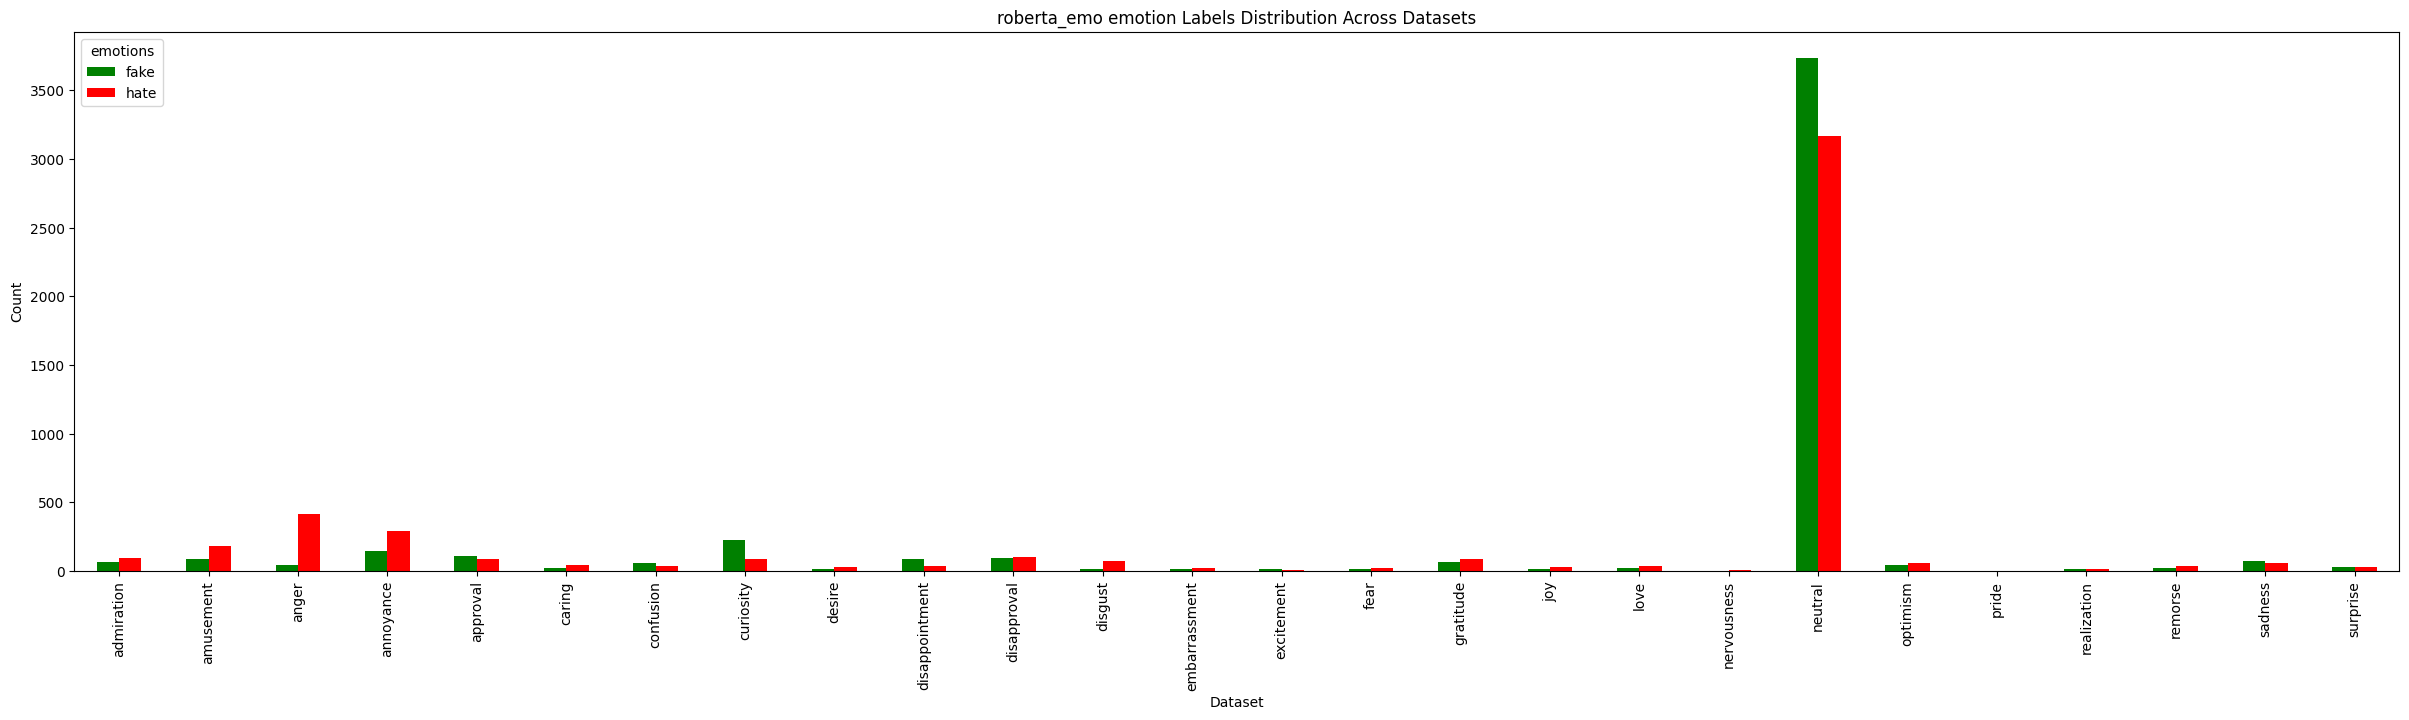


plotting the sankey charts for the emotions in each dataset




text cleaning and preprocessing!



 Computing and visualizing the cosine similarity

Average Cosine Similarity: 0.10861480236053467

 data cleaning and preprocessing


plotting the mean word lenght for both datasets


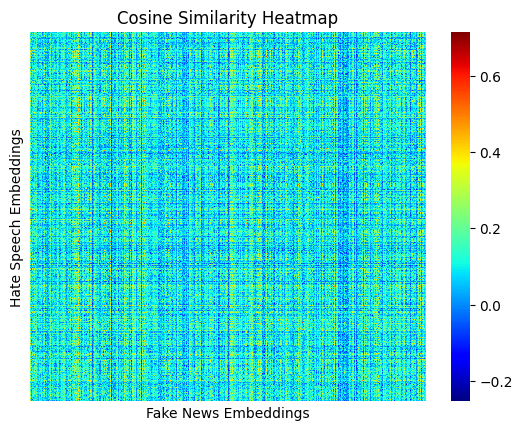

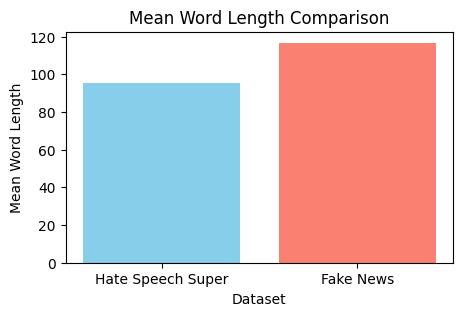


This Script Has finished running!


In [6]:
#output path to save the iamages

path = Path('/content/drive/MyDrive/PhD with Rawat/obj1_d1')
class Read:
    @staticmethod
    def read_and_filter_dataset (filepath, text_column, max_length=1000):
        data = pd.read_csv(filepath, low_memory=False)
        # Filter rows based on text length
        data.dropna(inplace=True)
        data = data[data[text_column].str.len() <= max_length]
        return data

class PlotUtils:
    @staticmethod
    def plot_sentiment_distribution(sentiment_labels1, sentiment_labels2,model_name, name1, name2):
        sentiment_counts_1 = sentiment_labels1.value_counts()# Count the sentiment labels for each dataset
        sentiment_counts_2 = sentiment_labels2.value_counts()

        # Create a DataFrame to hold the counts
        sentiment_df = pd.DataFrame({
            'Positive': [sentiment_counts_1.get('Positive', 1), sentiment_counts_2.get('Positive', 1)], #add neutral
            'Negative': [sentiment_counts_1.get('Negative', 0), sentiment_counts_2.get('Negative', 0)]
        })

        # filenames for exporting the images
        sentiment_dist = f"sentiment_dict_{name1}_vs_{name2}.png"

        # Set the index to be the dataset labels for easy plotting
        sentiment_df.index = [name1, name2]
        # Plot
        sentiment_df.plot(kind='bar', stacked=False, figsize=(5, 3), color=['green', 'red'])
        plt.title(f'{model_name} Sentiment Labels Distribution Across Datasets')
        plt.xlabel('Dataset')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.legend(title="Sentiment", loc='upper left')
        plt.savefig(path/sentiment_dist)
        plt.show()

class LLM_sentiment:
    def sentiment_gpt(self, event, model_name):
      prompt = f"Based on the context of the following {event}, classify its sentiment as strictly one of the following labels: 'Positive', 'Negative', or 'Neutral'. Respond with only the label and no additional explanation."
      client = OpenAI(
          api_key = userdata.get("OPEN_AI"),
          )
      input = [{"role": "system", "content": "You are a helpful assistant."},
              {"role": "user","content": prompt,}]
      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )
      output = chat_completion.choices[0].message.content
      return output

class BERTemotion:
      # following emotion classification from this following benchmark: https://huggingface.co/SamLowe/roberta-base-go_emotions
    def __init__(self,  max_length = 512, emotions_color = None, task ="text-classification",  sent_model_name="SamLowe/roberta-base-go_emotions"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.classifier = pipeline(task="text-classification", model=sent_model_name, top_k=True, device=0 if torch.cuda.is_available() else -1)
        self.emotion_colors = {
                      "admiration": "gold",
                      "anger": "cadetblue",
                      "approval": "orange",
                      "caring": "pink",
                      "curiosity": "darkviolet",
                      "desire": "cornflowerblue",
                      "disappointment": "bisque",
                      "disapproval": "moccasin",
                      "disgust": "silver",
                      "love": "turquoise",
                      "neutral": "tomato",
                      "optimism": "yellow",
                      "sadness": "pink"
                  }

    def predict(self, text):
        truncated_text = text[:self.max_length]
        model_outputs = self.classifier(truncated_text)
        # model_outputs = self.classifier(text)
        return {
            "emotion": model_outputs[0][0]['label'],
            "emotion_score": model_outputs[0][0]['score']
        }

    def plot_emotion_distribution(self, emotion_labels1, emotion_labels2, model_name, name1, name2):
          """Plots sentiment distribution."""
          emotion_counts_1 = emotion_labels1.value_counts()# Count the sentiment labels for each dataset
          emotion_counts_2 = emotion_labels2.value_counts()

          # save counts in DataFrame for easy plotting
          emotion_dict = pd.DataFrame({
              name1: emotion_counts_1,
              name2: emotion_counts_2,
          })
          emotion_dict = emotion_dict.sort_index()

          # Plot the bar chart
          emotion_dist = f"emotion_dict_{name1}_{name2}.png"
          emotion_dict.plot(kind='bar', stacked=False, figsize=(30, 7), color=['green', 'red'])
          plt.title(f'{model_name} emotion Labels Distribution Across Datasets')
          plt.xlabel('Dataset')
          plt.ylabel('Count')
          plt.xticks(rotation=90)
          plt.legend(title="emotions", loc='upper left')
          plt.savefig(path/emotion_dist)
          plt.show()

    def random_color(self):
      return f"#{random.randint(0, 0xFFFFFF):06x}"
    #This sankey charts will help us visualize the distribution of emotion across each dataset
    def emotion_counts(self, data):
      return data.value_counts().to_dict()
    def create_sankey_chart(self, data, dataset_name):
        emotion_count_dict = self.emotion_counts(data)
        all_emotions = list(emotion_count_dict.keys())
        nodes = all_emotions + [dataset_name]
        node_indices = {node: idx for idx, node in enumerate(nodes)}
        links = {
            "source": [],
            "target": [],
            "value": [],
            "color": []
        }
        for emotion, count in emotion_count_dict.items():
            links["source"].append(node_indices[emotion])
            links["target"].append(node_indices[dataset_name])
            links["value"].append(count)
            # links["color"].append(self.random_color())
            links['color'].append(self.emotion_colors.get(emotion.lower(), "black"))

        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes),
            link=dict(
                source=links["source"],
                target=links["target"],
                value=links["value"],
                color=links["color"])
        ))
        fig.update_layout(title_text=f"Emotion Flow for {dataset_name}", font_size=10)
        sankey_chart = f"sankey_chart_for_{dataset_name}.png"
        fig.write_image(path/sankey_chart)
        fig.show()

class Analysis:
    def __init__(self, n_grams = [(2, 2), (3, 3), (4, 4)]):
        self.n_grams = n_grams

    def exploratory_data_analysis(self, data, text):
        data['length'] = data[text].str.len()
        data['word_count'] = data[text].apply(lambda x: len(x.split()))
        data['mean_word_length'] = data[text].apply(lambda x: np.mean([len(word) for word in x.split()]))
        # data['mean_sent_length'] = data[text].apply(lambda x: np.mean([len(sent) for sent in sent_tokenize(x)]))
        return data

    def plot_mean_word_length(self, dataset1, dataset2, name1, name2):
        # Calculate the mean word length for each dataset
        mean_word_length_1 = dataset1['length'].mean()
        mean_word_length_2 = dataset2['length'].mean()
        results_df = pd.DataFrame({
            "Dataset": [name1, name2],
            "Mean Word Length": [mean_word_length_1, mean_word_length_2]
        })
        # Generate filenames for exporting the images
        word_dist = f"word_distri_{name1}_vs_{name2}.png"
        # Plot the data
        plt.figure(figsize=(5, 3))
        plt.bar(results_df["Dataset"], results_df["Mean Word Length"], color=['skyblue', 'salmon'])
        plt.xlabel("Dataset")
        plt.ylabel("Mean Word Length")
        plt.title("Mean Word Length Comparison")
        plt.savefig(path/word_dist)
        plt.show()

'''This is the chosen model to calculate the fake news and hate speech embeddings. see https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
It is a sentence transformer types, Model size is small, manageable and memory efficient, currently very hot in the community with 69M monthly downloads,
performs well on pair classification and STS task'''

class AllCosineSimilarity:
    def __init__ (self, batch_size = 10, model_name= "sentence-transformers/all-MiniLM-L6-v2"):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
      self.model = transformers.AutoModel.from_pretrained(model_name).to(self.device)
      self.batch_size = batch_size

    #Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self, model_output, attention_mask):
      token_embeddings = model_output[0] #First element of model_output contains all token embeddings
      input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
      return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def tokenize_text(self, data):
      if isinstance(data, pd.Series):
          data = data.tolist()
      return self.tokenizer(
          data,
          truncation=True,
          padding=True,
          max_length=512,
          return_tensors="pt"
      )

    def compute_embeddings(self, tokenized_input):
        tokenized_input = {k: v.to(self.device) for k, v in tokenized_input.items()}
        with torch.no_grad():
            model_output = self.model(**tokenized_input)
        embeddings = self.mean_pooling(model_output, tokenized_input['attention_mask'])
        return embeddings

    def normalize_embeddings(self, embeddings):
      return F.normalize(embeddings, p=2, dim=1)

    def calculate_cosine_similarity(self, hate_embeddings, fake_embeddings):
      return hate_embeddings @ fake_embeddings.T

    def visualize_similarity(self, cosine_sim_matrix):
        cosine_sim_matrix_np = cosine_sim_matrix.detach().cpu().numpy()
        average_similarity = cosine_sim_matrix.mean().item()
        sns.heatmap(cosine_sim_matrix_np, cmap="jet", xticklabels=False, yticklabels=False)
        plt.title("Cosine Similarity Heatmap")
        plt.xlabel("Fake News Embeddings")
        plt.ylabel("Hate Speech Embeddings")
        print("Average Cosine Similarity:", average_similarity)
        return average_similarity

def main():
   # Initialize the classes
    preprocessor = Preprocessor()
    reader = Read()
    analyser = Analysis()
    emotion = BERTemotion()
    llm_sent = LLM_sentiment()
    plots = PlotUtils()
    # cde_sim = CDECosineSimilarity()
    minilm_sim = AllCosineSimilarity()

    # Authenticate with Kaggle API
    kaggle.api.authenticate()

    hate_speech = reader.read_and_filter_dataset('/content/en_hf_102024.csv', 'text')
    fake_data = reader.read_and_filter_dataset('/content/Truth_Seeker_Model_Dataset.csv', 'tweet')

    #remove duplicates and keep only tthe first occurences
    hate_speech.drop_duplicates(keep='first', inplace = True, ignore_index= True)
    fake_data.drop_duplicates(keep='first', inplace = True, ignore_index= True)

    "for better accuracy, we consider only istances where the 5 (totally agree or majority agree) and the 3 crowdsources all agreed. for better credibility"
    fake_news = fake_data[(fake_data['3_label_majority_answer'] == 'Agree') & (fake_data['5_label_majority_answer'] == 'Agree')]
    abbrev_profanity = pd.read_excel('/content/abbreviation-list-english/abbreviations_eng.xls')

    # Extract DataFrame to include only rows with label = 1
    hate_speech_super_df = hate_speech.loc[hate_speech['labels'] == 1, ['text', 'labels']].sample(n=5000, random_state=42).reset_index(drop=True)
    fake_news_df = fake_news.loc[fake_news['BinaryNumTarget'] == 1, ['tweet', 'BinaryNumTarget']].sample(n=5000, random_state=42).reset_index(drop=True)
    abbrev_profanity = abbrev_profanity[['abbr', 'long']]

    print(f'\nThe shape of the hate dataset is {hate_speech_super_df.shape} while that of the fake dataset is {fake_news_df.shape}')

    '''#apply sentiment classification
    tqdm.pandas()

    print('\nStarting sentiment analysis!')
    print('\n')

    #hate
    hate_speech_super_df["sentiment"] = hate_speech_super_df["text"].progress_apply(lambda x: llm_sent.sentiment_gpt(x, 'gpt-4o-mini')) #gpt-4o-mini
    # the sentiment column may contain newline characters
    hate_speech_super_df["sentiment"] = hate_speech_super_df["sentiment"].replace(r'\n', ' ', regex=True)

    #fake
    fake_news_df["sentiment"] = fake_news_df["tweet"].progress_apply(lambda x: llm_sent.sentiment_gpt(x, 'gpt-4o-mini'))
    # the sentiment column may contain newline characters
    fake_news_df["sentiment"] = fake_news_df["sentiment"].replace(r'\n', ' ', regex=True)

    print('\nPlotting the sentiment distribution for the hate speech and fake news datasets)

    plots.plot_sentiment_distribution(hate_speech_super_df['sentiment'], fake_news_df['sentiment'], 'gpt-4o-mini', 'Hate Speech Super', 'Fake News')

    print('\nsentiment distribution for both datasets based on GPT-4o-Mini')

    print(hate_speech_super_df['sentiment'].value_counts(normalize=True))
    print(fake_news_df['sentiment'].value_counts(normalize=True))'''

    #fake
    fake_news_df['emotion'] = fake_news_df['tweet'].apply(lambda x: emotion.predict(x)['emotion'])
    fake_news_df['emotion_score'] = fake_news_df['tweet'].apply(lambda x: emotion.predict(x)['emotion_score'])
    #hate
    hate_speech_super_df['emotion'] = hate_speech_super_df['text'].apply(lambda x: emotion.predict(x)['emotion'])
    hate_speech_super_df['emotion_score'] = hate_speech_super_df['text'].apply(lambda x: emotion.predict(x)['emotion_score'])

    print('\nplotting the emotion distribution for each datasets')

    emotion.plot_emotion_distribution(
    fake_news_df['emotion'],
    hate_speech_super_df['emotion'],
    'roberta_emo',
    'fake',
    'hate')

    print("\nplotting the sankey charts for the emotions in each dataset\n")
      # Create a Sankey chart for each dataset
    emotion.create_sankey_chart(hate_speech_super_df['emotion'], "hate_speech")
    emotion.create_sankey_chart(fake_news_df['emotion'], "fake_news")

    print('\ntext cleaning and preprocessing!')
    print('\n')
    #preprocess the original datasets
    hate_speech_super_df['cleaned_processed_text'] = hate_speech_super_df['text'].apply(preprocessor.text_preprocessing)
    fake_news_df['cleaned_processed_text'] = fake_news_df['tweet'].apply(preprocessor.text_preprocessing)

    # Tokenize cleaned data column
    hate_speech_docs = minilm_sim.tokenize_text(hate_speech_super_df["cleaned_processed_text"])
    fake_news_docs = minilm_sim.tokenize_text(fake_news_df["cleaned_processed_text"])

    print("\n Computing and visualizing the cosine similarity\n")
    # Compute embeddings
    hate_embeddings = minilm_sim.compute_embeddings(hate_speech_docs)
    fake_embeddings = minilm_sim.compute_embeddings(fake_news_docs)
    # normalize the embeddings
    hate_normalized = minilm_sim.normalize_embeddings(hate_embeddings)
    fake_normalized = minilm_sim.normalize_embeddings(fake_embeddings)
    # Compute cosine similarity
    cosine_sim_matrix = minilm_sim.calculate_cosine_similarity(hate_normalized, fake_normalized)
    # Visualize results
    minilm_sim.visualize_similarity(cosine_sim_matrix)

    print("\n data cleaning and preprocessing\n")
    exploratory_hate= analyser.exploratory_data_analysis(hate_speech_super_df, 'cleaned_processed_text')
    exploratory_fake = analyser.exploratory_data_analysis(fake_news_df, 'cleaned_processed_text')

    print('\nplotting the mean word lenght for both datasets')
    #plot the mean word length statistics for each dataset
    analyser.plot_mean_word_length(hate_speech_super_df, fake_news_df, 'Hate Speech Super', 'Fake News')

    print("\nThis Script Has finished running!")
    return hate_speech_super_df, fake_news_df

if __name__ == "__main__":
    hate_speech_super_df, fake_news_df = main()
    #save new dataframes to output folder as csv files
    hate_speech_path = path/"new_hate_speech_df.csv"
    fake_news_path = path/"new_fake_news_df.csv"

    hate_speech_super_df.to_csv(hate_speech_path, index=False)
    fake_news_df.to_csv(fake_news_path, index=False)


## Check out the code for the topic modelling >> https://colab.research.google.com/drive/1K6bQQM_NxBlFlwpj4AaACICJlM2xQyu0?usp=sharing

# Stop here for now

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("jxm/cde-small-v1", trust_remote_code=True)

sentences = [ "The weather is lovely today.", "It's so sunny outside!", "He drove to the stadium." ]

embeddings = model.encode(sentences)

similarities = model.similarity(embeddings, embeddings) print(similarities.shape)

following the colab notebook:

https://colab.research.google.com/drive/1r8xwbp7_ySL9lP-ve4XMJAHjidB9UkbL?usp=sharing

The CDE model's two-stage process namely:

The first-stage embeddings (dataset_embeddings) provide a semantic "background" for the second-stage model.

The second-stage embeddings are the ones directly used for cosine similarity calculations.

# code for the CDE embeddings

- adapted from following code implmentation adapted from following colab notebook: https://colab.research.google.com/drive/1r8xwbp7_ySL9lP-ve4XMJAHjidB9UkbL?usp=sharing\n")

In [ ]:
class CDECosineSimilarity:
    def __init__ (self, batch_size = 10, model_name= "jxm/cde-small-v1", tokenizer_model = "bert-base-uncased" ):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_model)
      self.model = transformers.AutoModel.from_pretrained(model_name, trust_remote_code=True).to(self.device)
      self.batch_size = batch_size
      self.dataset_embeddings = None  # Placeholder for first-stage embeddings


    def tokenize_text(self, data):
      if isinstance(data, pd.Series):
          data = data.tolist()
      return self.tokenizer(
          data,
          truncation=True,
          padding=True,
          max_length=512,
          return_tensors="pt"
      )

    def compute_first_stage_embeddings(self, tokenized_docs):
        tokenized_docs = tokenized_docs.to(self.device)
        embeddings = []
        for i in tqdm(range(0, len(tokenized_docs["input_ids"]), self.batch_size)):
            batch = {k: v[i:i + self.batch_size] for k, v in tokenized_docs.items()}
            with torch.no_grad():
                embeddings.append(self.model.first_stage_model(**batch))
        self.dataset_embeddings = torch.cat(embeddings)  # Store for second stage
        return self.dataset_embeddings

    def compute_second_stage_embeddings(self, tokenized_docs):
        if self.dataset_embeddings is None:
            raise ValueError("First-stage embeddings must be computed before second-stage embeddings.")
        tokenized_docs = tokenized_docs.to(self.device)
        embeddings = []
        embeddings.append(
            self.model.second_stage_model(
                input_ids=tokenized_docs["input_ids"],
                attention_mask=tokenized_docs["attention_mask"],
                dataset_embeddings=self.dataset_embeddings
            )
        )
        second_stage_embeddings = torch.cat(embeddings)
        return second_stage_embeddings

    def normalize_embeddings(self, embeddings):
      return embeddings / embeddings.norm(p=2, dim=1, keepdim=True)

    def calculate_cosine_similarity(self, hate_embeddings, fake_embeddings):
      return hate_embeddings @ fake_embeddings.T

    def visualize_similarity(self, cosine_sim_matrix):
        cosine_sim_matrix_np = cosine_sim_matrix.detach().cpu().numpy()
        average_similarity = cosine_sim_matrix.mean().item()
        sns.heatmap(cosine_sim_matrix_np, cmap="jet", xticklabels=False, yticklabels=False)
        plt.title("Cosine Similarity Heatmap")
        plt.xlabel("Fake News Embeddings")
        plt.ylabel("Hate Speech Embeddings")
        print("Average Cosine Similarity:", average_similarity)
        return average_similarity